In [1]:
import sys
import collections
import numpy as np
from scipy.stats import norm

%matplotlib notebook
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib import gridspec

# Settings

In [2]:
# Parameter values used to generate data
thetas = np.linspace(-1.,0.,6)
n_thetas = len(thetas)

# Two benchmark parameter values
theta0 = 1
theta1 = 2
print(thetas[theta0], thetas[theta1])

# Observable range
n_positions = 32
xmin = 0
xmax = n_positions - 1
x_values = np.linspace(xmin, xmax, n_positions)

# Which z trajectory to plot
example_theta = theta0
example_trajectories = [15, 37]

# How many samples for example histogram
n_samples_histo = 100

-0.8 -0.6


# Load data

In [3]:
# Augmented data. Shape (n_thetas, n_samples)
x = np.load('data/x.npy')
# r_xz = np.load('data/r_xz.npy') # Not yet implemented in simulator
t_xz = np.load('data/t_xz.npy')

# Nail positions / thresholds. Shape (n_thetas, n_rows, n_nails)
nail_positions = np.load('data/nail_positions.npy')
n_rows, n_nails = nail_positions[theta0].shape
assert n_nails == n_positions - 1

# Example trajectories. Shape (n_thetas, n_rows + 2), consisting of (begin, z, x)
trajectories = np.load('data/trajectories.npy')


In [4]:
for x_final in range(n_positions):
    candidates = []
    for i, tr_ in enumerate(trajectories[theta0]):
        if tr_[-1] == x_final:
            candidates.append(i)
    if len(candidates) > 0:
        print(x_final, candidates)

6 [60, 73, 75]
7 [46, 74, 79]
8 [10, 63, 94]
9 [7, 22, 43, 59, 67, 81, 84]
10 [76, 96]
11 [3, 15, 34, 37]
12 [9, 12, 25, 48, 50, 54, 70, 72, 77, 82, 97]
13 [51, 78]
14 [30, 33, 65, 95]
15 [5, 17, 29, 40, 57, 58, 62, 87, 93]
16 [6, 8, 35, 36, 39, 44, 52, 61, 83, 85, 88]
17 [26, 41, 56, 66, 68, 90]
18 [13, 14, 16, 24, 80, 89]
19 [1, 18, 19, 23, 28, 32, 38, 49, 55, 86, 92, 99]
20 [2, 4, 11, 64, 71, 91]
21 [27]
22 [20, 21, 31, 42, 45, 69, 98]
23 [53]
24 [0, 47]


# "True" densities and ratios from histogram

In [5]:
p_x, p_hat_x = [], []

for x_ in x:
    histo, _ = np.histogram(x_, bins=n_positions, range=(xmin - 0.5, xmax + 0.5), density=True)
    p_x.append(histo)
    histo, _ = np.histogram(x_[:n_samples_histo], bins=n_positions, range=(xmin - 0.5, xmax + 0.5), density=True)
    p_hat_x.append(histo)
    
p_x = np.asarray(p_x)
p_hat_x = np.asarray(p_hat_x)

r_x = p_x / p_x[theta1]
s_x = 1. / (1. + r_x)


/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# Plotting settings

In [6]:
colors = ['#CC002E', 'orange', 'mediumblue', 'darkgreen', 'c', '#be96ff', '0.65', 'black']


In [7]:
our_cmap = mpl.colors.LinearSegmentedColormap.from_list(name='rascascal', 
                                                       colors =['#CC002E', '0.85', 'mediumblue'],
                                                       N=201)
our_cmap_r = mpl.colors.LinearSegmentedColormap.from_list(name='rascascal_r', 
                                                          colors =['mediumblue', '0.85', '#CC002E', ],
                                                          N=201)

def cmap_color(x, xmin=0., xmax=1.):
    #cmap = mpl.cm.RdYlBu
    return our_cmap((x - xmin) / (xmax - xmin))

def viridis_color(x, xmin=0., xmax=1.):
    cmap = mpl.cm.viridis
    return cmap((x - xmin) / (xmax - xmin))

In [8]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_sep_small_absolute = 8. * 0.005
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.12
margin_b_absolute = 8. * 0.08

def custom_figure(n_panels=2, width=8., panel_aspect_ratio=1.,
                  extra_top_space=False, reduce_vertical_sep=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate vertical margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    if reduce_vertical_sep:
        margin_sep_total = (margin_sep_small_absolute / height)
    else:
        margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # New figure
    fig = plt.figure(figsize=(width, height))
    
    # Adjust margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    
    return fig


# Plot Plinko board, example trajectory, and histograms

<IPython.core.display.Javascript object>


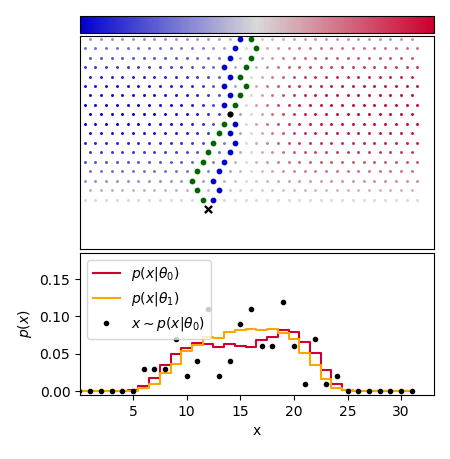

/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


In [10]:
fig = custom_figure((1,2), 4.5, 2.5, reduce_vertical_sep=True)
#gs = gridspec.GridSpec(4, 1, height_ratios=[0.12, 0.18, 1.5, 1])
gs = gridspec.GridSpec(3, 1, height_ratios=[0.12, 1.5, 1])
#gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])



#ax0 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[2])

for i, t in enumerate([theta0, theta1]):
    plt.step(x_values, p_x[t], where='mid',
             c=colors[i], lw=1.5, ls='-',
             label=r'$p(x|\theta_' + str(i) + '$)')
    
plt.plot(x_values, p_hat_x[theta0],
         color='black', ls=' ', marker='o', ms=3.,
         label=r'$x \sim p(x | \theta_0)$')
    
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('$p(x)$')
plt.xlim(xmin - 0.5, xmax + 0.5)
plt.ylim(-0.005,0.185)



#ax = plt.subplot(gs[2], sharex=ax0)
ax = plt.subplot(gs[1], sharex=ax0)

for r in range(n_rows):
    offset = 0.5 if r % 2 == 0 else 0

    for i in range(n_nails + (0 if r % 2 == 0 else 1)):
        nail_position = nail_positions[example_theta][r,min(i, n_nails - 1)]
        plt.scatter([offset + i + 0.5], [-r],
                    color=cmap_color(nail_position), 
                    s=5., marker=".", alpha=1.)

for i, ex in enumerate(example_trajectories):
    trajectory = trajectories[example_theta, ex]
    pos = trajectory[0]
    z = trajectory[1:-1]
    x_ = trajectory[-1]

    for r in range(n_rows):
        offset = 0.5 if r % 2 == 0 else 0
        plt.scatter([offset + pos + 0.5], [-r],
                    color='black' if r in [0,1,10] else colors[2+i], 
                    s=10., marker="o", alpha=1.)
        
        if z[r] == 0:
            if r % 2 == 0:
                pos = pos 
            else:
                pos = pos - 1
        else:
            if r % 2 == 0:
                pos = pos + 1
            else:
                pos = pos 

    offset = 0.5 if (r+1) % 2 == 0 else 0
    plt.scatter([offset + x_ + 0.5], [-r-1], marker="x", color=colors[-1], s=25.)

plt.xlim(xmin - 0.5, xmax + 1.5)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)



ax = plt.subplot(gs[0])

norm = mpl.colors.Normalize(vmin=0., vmax=1.)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=our_cmap_r,
                                norm=norm,
                                orientation='horizontal')
cb1.set_ticks([])
#cb1.set_ticks([0.,1.])
#cb1.set_ticklabels(['Left', 'Right'])



plt.savefig('figures/plinko_histogram.pdf')


# CARL plot

<IPython.core.display.Javascript object>


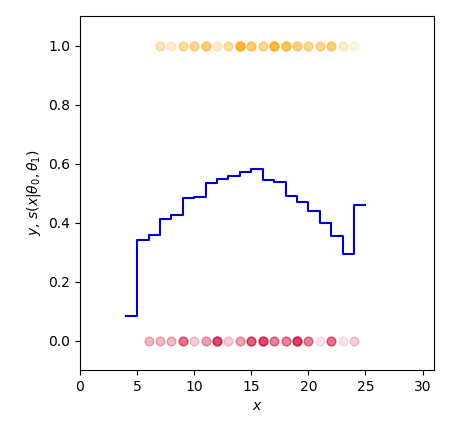

In [11]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.gca()

plt.scatter(x[theta0][:n_samples_histo], np.zeros_like(x[theta0][:n_samples_histo]),
            s=40., c=colors[0], alpha=.1,
            label=r'$x \sim p(x | \theta_0)$')
plt.scatter(x[theta1][:n_samples_histo], np.ones_like(x[theta1][:n_samples_histo]),
            s=40., c=colors[1], alpha=.1,
            label=r'$x \sim p(x | \theta_0)$')
plt.step(x_values, s_x[theta0], color=colors[2], lw=1.5)

#plt.legend(loc='upper left',frameon=False)

plt.xlabel('$x$')
plt.ylabel(r'$y$, $s(x| \theta_0, \theta_1)$')

plt.xlim(xmin,xmax)
plt.ylim(-0.1,1.1)
ax.set_yticks([0.,0.2,0.4,0.6,0.8,1.])

plt.savefig("figures/plinko_carl.pdf")

# 3D plot

<IPython.core.display.Javascript object>


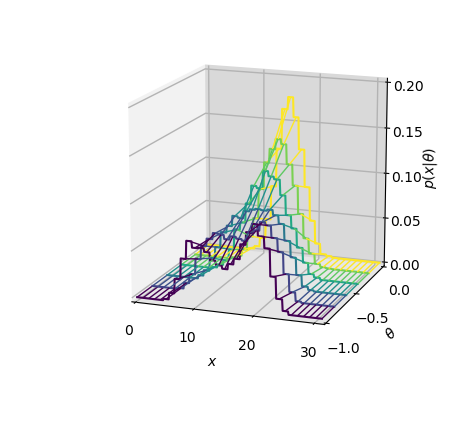

In [12]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.subplot(1,1,1, projection='3d')

ax.view_init(elev=15., azim=-70)

# Lines with constant theta
for t, theta in reversed(list(enumerate(thetas))):
    x_ = np.linspace(xmin, xmax, n_positions * 10)
    p_ = np.asarray([p_x[t][int(round(xi,0))] for xi in x_])
    theta_ = theta * np.ones_like(x_)
    
    ax.plot(x_, theta_, p_,
            c=viridis_color(theta, -1., 0.), lw=1.5, alpha=1.)

# Lines of constant x
for x_ in range(n_positions):
    segments = []
    for t in range(n_thetas - 1):
        theta_begin = thetas[t]
        theta_end = thetas[t+1]
        p_begin = p_x[t][x_]
        p_end = p_x[t + 1][x_]
        segments.append( [(x_, theta_begin, p_begin), (x_, theta_end, p_end)] )
    segments = np.asarray(segments)

    lc = Line3DCollection(segments, cmap='viridis')
    lc.set_array(thetas[:-1])
    lc.set_linewidth(1.)
    lc.set_alpha(1.)

    ax.add_collection(lc)
    
ax.set_xlabel('$x$')
ax.set_zlabel(r'$p(x| \theta)$')
ax.set_ylabel(r'$\theta$')
ax.set_xlim(0.,31.)
ax.set_zlim(0., 0.2)
ax.set_ylim(-1.,0.)
ax.set_xticks(np.linspace(0.,30.,4))
ax.set_yticks([-1.,-0.5,0.])
ax.set_zticks([0.,0.05,0.1,0.15,0.2])

ax.dist = 10.

ax.w_xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.w_yaxis.set_pane_color((0.85, 0.85, 0.85, 1.0)) 
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0)) 
ax.w_xaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 1.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})
ax.w_yaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 0.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})
ax.w_zaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 1.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})

plt.savefig('figures/plinko_3d.pdf')
